In [115]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [116]:
%config InlineBackend.figure_format = 'retina'

In [117]:
# define some parameters
random_seed = 40	# 随机种子
lr = 0.001			# 学习率
batch_size = 32		# 批量大小
n_epochs = 15		# 迭代次数
img_size = 32		# 图像尺寸
n_classes = 10		# 分类数量

## 数据预处理

In [118]:
# 定义 transforms
# transforms.ToTensor() 可以自动将images变到【0，1】范围
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 下载和制作数据集, 第一次需要打开download
train_dataset = datasets.FashionMNIST(root="data", train=True, transform=transforms, download=False)
valid_dataset = datasets.FashionMNIST(root="data", train=False, transform=transforms)

# 定义数据集加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 分类
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 显示函数
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## 画出图像集

Text(0.5, 0.98, 'MNIST Dataset - preview')

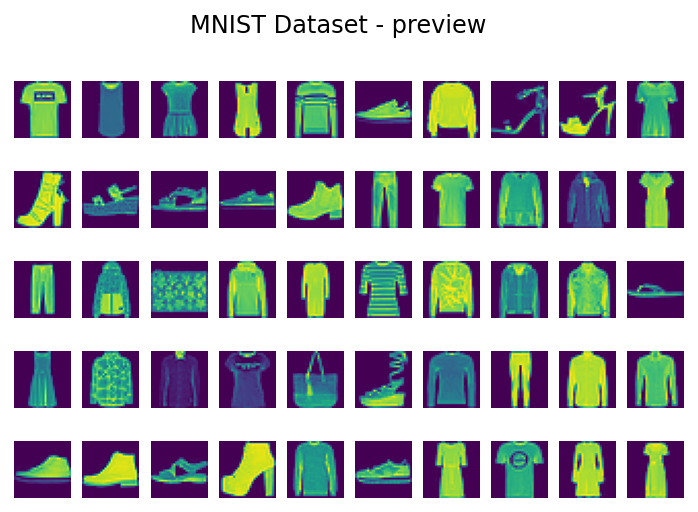

In [119]:
row_img = 10
n_rows = 5

fig = plt.figure()
for index in range(1, row_img * n_rows + 1):
	plt.subplot(n_rows, row_img, index)
	plt.axis('off')
	plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview')

## 构建LeNet-5网络

In [120]:
class LeNet5(nn.Module):
	'''
	构建 LeNet5 网络
	'''
	def __init__(self):
		super(LeNet5, self).__init__()
		self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
		self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
		self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
		self.lin1 = nn.Linear(16*4*4, 120)
		self.lin2 = nn.Linear(120, 84)
		self.lin3 = nn.Linear(84, 10)
	
	def forward(self, x):
		x = self.pool(F.tanh(self.conv1(x)))
		x = self.pool(F.tanh(self.conv2(x)))
		x = x.view(-1, 16*4*4)
		x = F.tanh(self.lin1(x))
		x = F.tanh(self.lin2(x))
		x = self.lin3(x)
		return x

net = LeNet5()

In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)

## 设置 TensorBoard

In [122]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

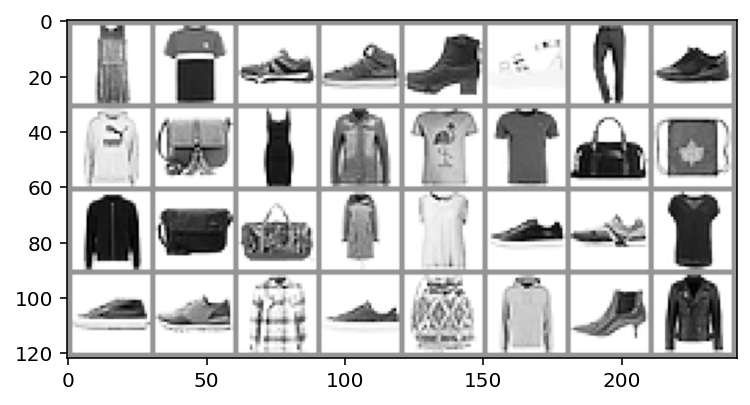

In [123]:
# 获取一些随机的训练图片
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 设置images的grid
img_grid = torchvision.utils.make_grid(images)

# 显示images
matplotlib_imshow(img_grid, one_channel=True)

# 向tensorboard显示
writer.add_image('four_fashion_mnist_images', img_grid)

In [124]:
writer.add_graph(net, images)
writer.close()

In [125]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(train_dataset.data, train_dataset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [126]:
# helper functions

def images_to_probs(net, images):
    '''
    从经过训练的网络和图像列表生成预测和相应的概率
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    使用经过训练的网络以及批次中的图像和标签生成 matplotlib 图，
	该图显示网络的最高预测及其概率，以及实际标签，并根据预测是否正
	确为该信息着色。使用“images_to_probs”函数。
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [127]:
running_loss = 0.0
for epoch in range(n_epochs):  
	# loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [128]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)